## Introduction

The primary purpose of this notebook is to analyse the ratings that professors of Computer Science dept. at  Arizona State University get at ratemyprofessor.com and see if there are any pattern/behaviour among highly rated professors that makes them popular among students. 

There are multiple independent analysis performed in this notebook. At the start of each the methodology and aim is discussed, followed by the actual experiment and then by the inference.

For this analysis I have scrapped all the information from ratemyprofessor.com, the code for which can be found at - [Scrape_rate_myprofessor](https://github.com/monkeydunkey/Scrape_Rate_My_professor/blob/master/dataScrubber.py). If you want to perform the same analysis for some other University or department, just update the parameters in [Scrape_rate_myprofessor](https://github.com/monkeydunkey/Scrape_Rate_My_professor/blob/master/dataScrubber.py) and populate professors.csv and ratings.csv again.

In [2]:
# Importing all the libraries required fro the analysis
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

So we have 2 files
1. professors.csv - This file contains aggregate information about professors such as average ratings and number of ratings
2. ratings.csv - This file contains data regarding the various parameters on which students rated their professors

Even though we have 2 files professor.csv and ratings.csv we will do the analysis on ratings.csv only as it captures the student reponses at a more granular level. For any future analysis however the 2 files can be joined on 'TeacherID' column in ratings.csv and 'pk_id' column in professors.csv

In [3]:
# Load the 2 files into pandas dataframe. Dataframes works in a way similar to a table in standard database
professors = pd.read_csv('professors.csv')
ratings = pd.read_csv('ratings.csv')

In [4]:
# Check out the top 5 rows of the professors table
professors.head()

,schoolid_s,total_number_of_ratings_i,pk_id,averageratingscore_rf,teacherfirstname_t,teacherlastname_t
0,45,127,11705,3.99,Faye,Navabi
1,45,121,18588,2.40,Yinong,Chen
2,45,94,387339,4.21,Mutsumi,Nakamura
3,45,92,1011373,3.74,Janaka,Balasooriya
4,45,86,238319,2.30,Charles,Colbourn


In [6]:
# Check out the top 5 rows of the ratings table
ratings.head()

,rErrorMsg,rWouldTakeAgain,rClass,rTextBookUse,easyColor,teacherGrade,rEasy,rClarity,usefulGrouping,rInterest,...,onlineClass,notHelpCount,rHelpful,teacher,helpColor,rEasyString,unUsefulGrouping,rOverall,helpCount,clarityColor
0,NaN,Yes,CSE205,No,average,A,2,5,people,NaN,...,NaN,0,5,NaN,good,2.0,people,5.0,0,good
1,NaN,NaN,CSE110,Yes,average,B,3,3,people,NaN,...,NaN,1,4,NaN,average,3.0,person,3.5,0,average
2,NaN,NaN,CSE110,Yes,average,A,2,4,person,NaN,...,NaN,2,4,NaN,good,2.0,people,4.0,1,good
3,NaN,NaN,CSE205,No,average,B,3,5,person,NaN,...,NaN,1,4,NaN,good,3.0,person,4.5,1,good
4,NaN,NaN,CSE110,Yes,poor,A,1,5,person,NaN,...,NaN,1,4,NaN,good,1.0,person,4.5,1,good


### Experiment 1 - Are Second Chances given ?
Here we will try to understand the relation between the rating a professor received and how likely is a student who gave that rating take his or her class again. 

Notes about the figure
1. The radius of the circle is a representation of the number of students in that category for e.g. the circle at (5,0) is the representation of the # students who gave a professor rating of 5 but will not take their class again
2. Y axis represents whether or not the student will take the class again, with y = 1 as Yes and y = 0 as No

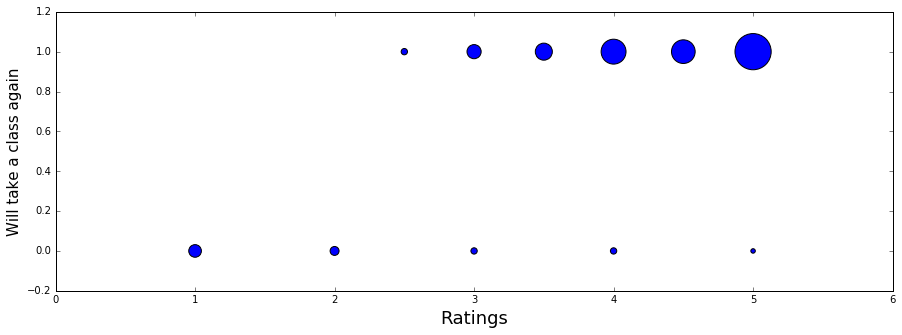

In [22]:
# Adding a new column 'rWouldTakeAgainB' which would contain 1 or 0 based on whether the student said yes or no 
ratings['rWouldTakeAgainB'] = ratings['rWouldTakeAgain'].map({'Yes':1, 'No':0})
tempDf = ratings[['rWouldTakeAgainB', 'rOverall']].copy().dropna()
# Count the number of students in each category
tempDf = tempDf.groupby( [ 'rOverall', 'rWouldTakeAgainB'] ).size().to_frame(name = 'count').reset_index()

# Setting the size of the figure
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.scatter(tempDf['rOverall'], tempDf['rWouldTakeAgainB'], s=tempDf['count']*10)
plt.xlabel('Ratings', fontsize=18)
plt.ylabel('Will take a class again', fontsize=15)

In [9]:
# This is the aggregated data from which the plot above was created
tempDf

,rOverall,rWouldTakeAgainB,count
0,1.0,0.0,16
1,2.0,0.0,8
2,2.5,1.0,4
3,3.0,0.0,4
4,3.0,1.0,20
5,3.5,1.0,29
6,4.0,0.0,4
7,4.0,1.0,62
8,4.5,1.0,56
9,5.0,0.0,2


### Inference
We can see that if a student gave a higher rating the chance of taking that professor's class again increase and vice versa . However for ratings below 2.5 students prefer not take a class with the professor again.

### Experiment 2 - Do good jokes matter ?
Here we will see the different tags a professor can receive and try to analyse if there is pattern on how students give these tags.

Notes about the figure
1. The y axis does not represent any information, it is used only to distribute out the points in the graph
2. The radius of the circle indicates the number of students who gave that tag

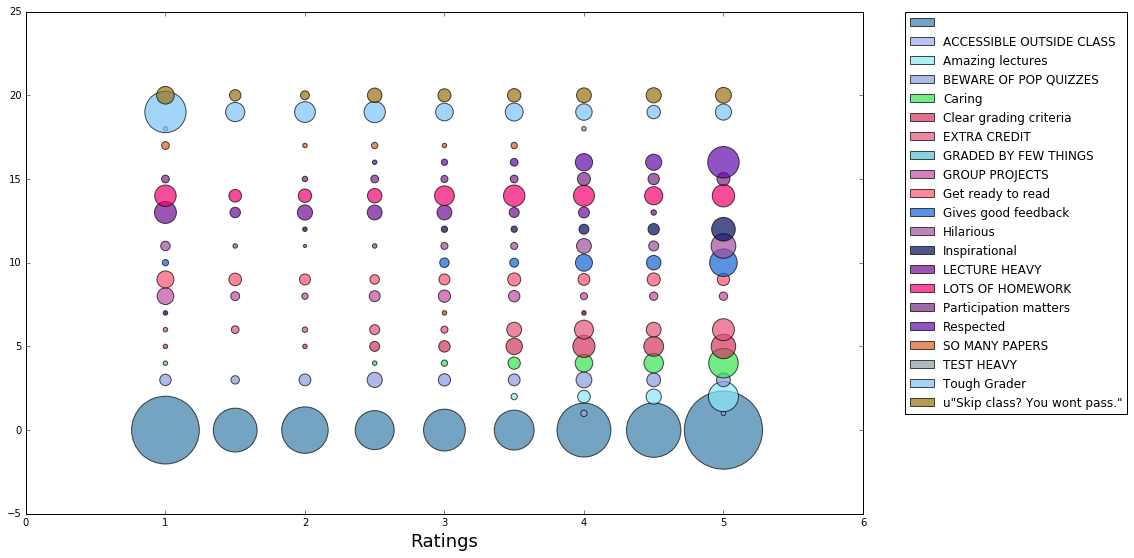

In [13]:
# get individual tags from 'teacherRatingTags' column and add a row for each of the tag
tags = ratings['teacherRatingTags'].copy().str.replace('[','').str.replace(']','').str.replace("u'",'').str.strip()\
.str.replace("'",'').str.split(',').apply(pd.Series, 1).stack()
tags.index = tags.index.droplevel(-1)
tags.name = 'Tags'
tempDf = ratings.join(tags)[['Tags', 'rOverall']]
tempDf['Tags'] = tempDf['Tags'].str.strip()
tempDf = tempDf.groupby( [ 'rOverall', 'Tags'] ).size().to_frame(name = 'count').reset_index()
tempDf['Numerical Tags'] = pd.Series(np.unique(tempDf['Tags'], return_inverse = True)[1])

# Setting the size of the figure
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots()
recs = []
classes = []
for i in sorted(tempDf['Numerical Tags'].unique()):
    color = np.random.rand(3,1)
    ax.scatter(tempDf[tempDf['Numerical Tags'] == i]['rOverall'], tempDf[tempDf['Numerical Tags'] == i]['Numerical Tags'], \
               s=tempDf[tempDf['Numerical Tags'] == i]['count']*10, c=color, alpha=0.7)
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color, alpha = 0.7))
    classes.append(tempDf[tempDf['Numerical Tags'] == i]['Tags'].unique()[0])
ax.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Ratings', fontsize=18)

### Inference
There are so many interesting pieces of information here, so lets get started.

First lets talk about the obvious ones. The higher rated professors are more respected, inspirational, caring, they give amazing lectures, have clear grading criterion and they encourage class participation. A common theme that can be noticed accross all of these tags is that they represent a person who cares about what they are doing. One who plans ahead leaving little or less room for any kind of uncertainity and most importantly one who loves their field of study and want to encourage others to do so as well.

We all hate lots of homework, surprise quizzes (especially the ones we miss) and the general need to attend lectures every day. These factors however do not affect the ratings at all. So a professor can give a lot of homework, pop quizes and make students come to lecture (I am not talking about mandatory attendence here) to understand the concepts required to pass the course and still the students would not resent him/her for doing so.

Finally to the interesting stuff. So there are 2 interesting pieces of information in the figure above.
1. Importance of jokes - If a professor cracks a lot many good jokes, chances are that they will get a higher rating. It kinds of make sense as jokes tend to humanize a professor, who is usually no less than a god in the course they are currently teaching. 
2. No one likes to read - I hope this not a problem caused due to shortening attention span in my generation but we hate to read a lot of text. This is especially true for us in Computer Science field, where we want to get things done as quickly as possible. But none the less as it turns out if a student has to read a lot they dont usually like the professor.

P.S. If you are trying to see the trends for your own self but are not able to find the legends easily, look in the order the legends are present, with the first one empty string at the bottom and so on


### Experiment 3 - Why such and expensive book ?
Here we will the relationship between the rating a student give and whether or not a book is required for professor's course. The aim is to try and see whether the high cost associated with book (usually the case in USA) which will be used only for a single course brings about any resentment towards the professor. 

Notes about the figure
1. The radius of the circle is a representation of the number of students in that category for e.g. the circle at (5,0) is the representation of the # students who gave a professor rating of 5 whose course did not require a book
2. Y axis represents whether or not a book was required, with y = 1 as Yes and y = 0 as No 

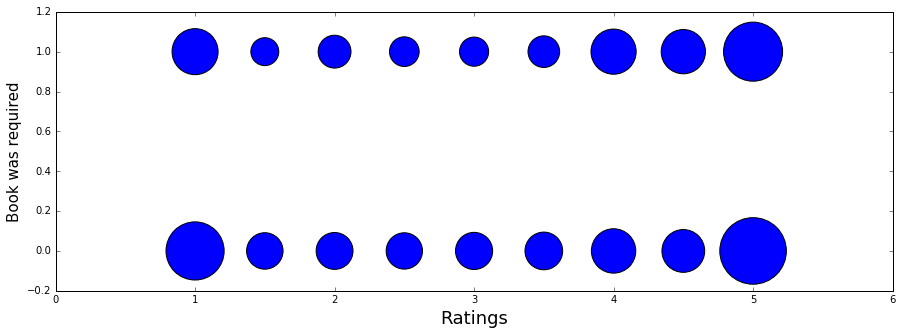

In [23]:
tempDf = ratings[['rOverall']].copy()
# Adding a new column 'rTextBookUseB' which would contain 1 or 0 based on whether a book was required or not 
tempDf['rTextBookUseB'] = ratings['rTextBookUse'].map({'Yes':1, 'No':0})
tempDf = tempDf.dropna()
tempDf = tempDf.groupby( [ 'rOverall', 'rTextBookUseB'] ).size().to_frame(name = 'count').reset_index()
# Setting the size of the figure
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.scatter(tempDf['rOverall'], tempDf['rTextBookUseB'], s=tempDf['count']*10)

plt.xlabel('Ratings', fontsize=18)
plt.ylabel('Book was required', fontsize=15)

### Inference
So as it turns not subscribing books which may be costly has no affect what so ever on the rating a student might give.

### Experiment 4 - I did better than that
Here we will analyse the relationship between the grades a professor give and the rating he/she receives.

Notes about the figure
1. The y axis does not represent any information, it is used only to distribute out the points in the graph
2. The radius of the circle indicates the number of students who gave a given letter grade

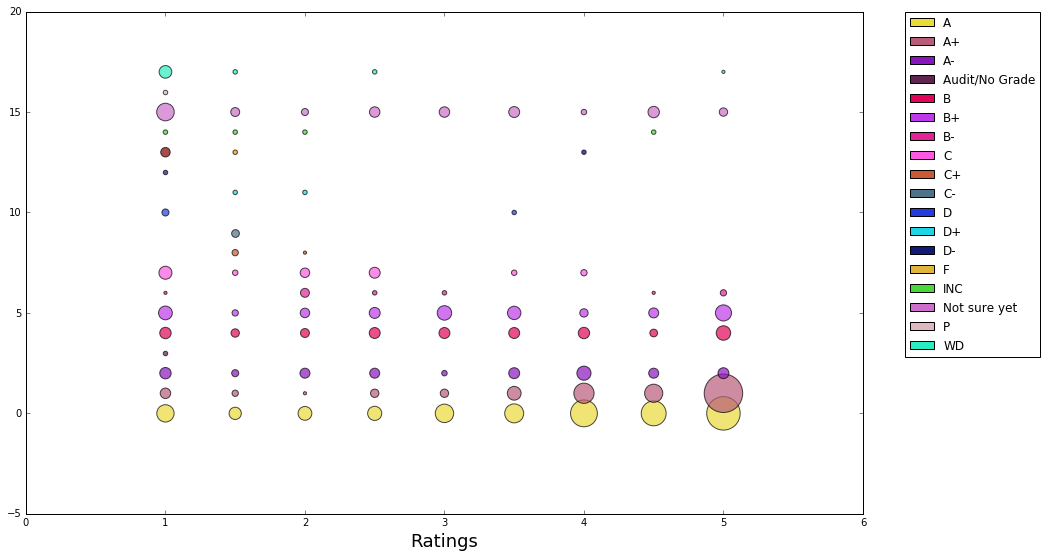

In [25]:
tempDf = ratings[['rOverall','teacherGrade']].copy().dropna()
tempDf = tempDf.groupby( [ 'rOverall', 'teacherGrade'] ).size().to_frame(name = 'count').reset_index()
tempDf['Numerical Grades'] = pd.Series(np.unique(tempDf['teacherGrade'], return_inverse = True)[1])

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots()
recs = []
classes = []
for i in sorted(tempDf['Numerical Grades'].unique()):
    color = np.random.rand(3,1)
    ax.scatter(tempDf[tempDf['Numerical Grades'] == i]['rOverall'], tempDf[tempDf['Numerical Grades'] == i]['Numerical Grades'], \
               s=tempDf[tempDf['Numerical Grades'] == i]['count']*10, c=color, alpha=0.7)
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color))
    classes.append(tempDf[tempDf['Numerical Grades'] == i]['teacherGrade'].unique()[0])
ax.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Ratings', fontsize=18)

### Inference
There is a clear relation ship between high rating and a high grade. One thing that can be inferred is that a student getting a higher grade might be biased towards giving the professor a higher rating but vice versa does not seem to be true. Hence, while looking at review of a professor with a high rating, reviews from student who got a lower grade might just be the ones to look for as they would be unbiased.

### Experiment 5 - Piece of cake
Here we will analyse the relationship between how easy a course offered by a professor is and the rating he/she receives.

Notes about the figure
1. The radius of the circle is a representation of the number of students in that category for e.g. the circle at (5,1) is the representation of the # students who gave a professor rating of 5 and who thought that the course was easy

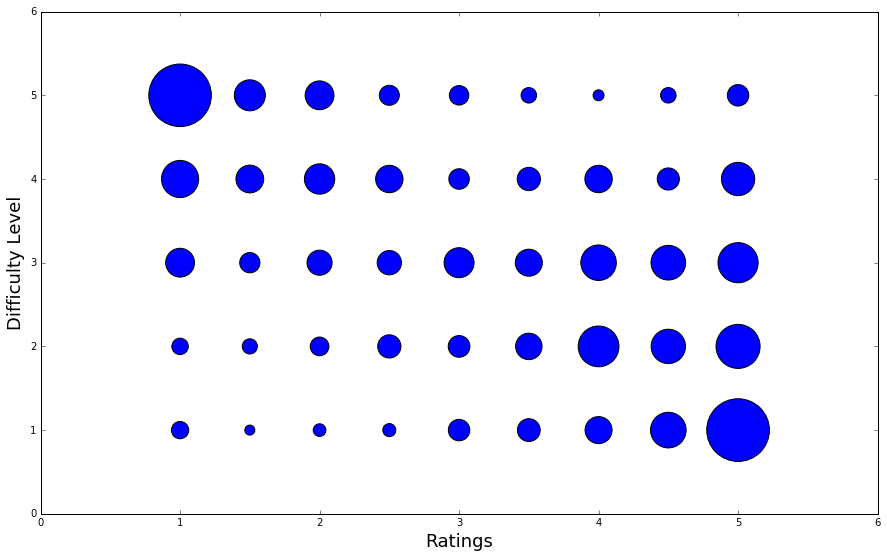

In [28]:
tempDf = ratings[['rOverall', 'rEasy']].copy()
tempDf = tempDf.dropna()
tempDf = tempDf.groupby( [ 'rOverall', 'rEasy'] ).size().to_frame(name = 'count').reset_index()
plt.scatter(tempDf['rOverall'], tempDf['rEasy'], s=tempDf['count']*10)
plt.ylabel('Difficulty Level', fontsize = 18)
plt.xlabel('Ratings', fontsize = 18)

### Inference
This is quite similar to the one we analyzed above, the easier the course the more the probability that the student will give a better grade. Here however the vice versa is also true that the lower a student rated a professor the harder he/she felt their course was. The difficulty level of a course is a subjective thing, there are 2 ways in my opinion that a course can be termed easy.
1. The course content was kept to a level low enough that it was very easy to understand
2. The professor explained the concepts in way that they were easy to understand.

If we were to accept the second explanation of the difficulty level to be true. Then it can be inferred that professors receive better rating if they are very articulate during lectures and can get the concepts accross to the student. This is again a repetition of what we saw during the analysis of the tags that highly rated professors give amazing lectures.

### Experiment 6 - Words for a professor
A common problem accross all the analysis that we have done till now is the absence of data. People usually dont fill in all the fields, the result of which is that value for many fields is NA or NULL. This was especially clear during the analysis of tags (Experiment 2) as evident by the radius of the circles corresponding to blank/NA across all the ratings.

Luckily however 99% of the people write comments, so we can use it to do analysis over the whole set of data we have. Unluckily though comments is an unstructured form of data and extracting information out of it is not as trivial as ones above.In this experiment we are going to Calculate [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf]) for all the [ngrams](https://en.wikipedia.org/wiki/N-gram) in comments section. 

The experiment's aim - Here we will try to find out the Top 10 most important phrases that appear in a comment associated with a given rating.

Notes about the figure
1. The radius of a circle is a representation of the TF-IDF score of a phrase for a given rating.
2. The X-axis was used to separate out the points

In [11]:
df = pd.read_csv('ratings.csv')[['rOverall', 'rComments']].dropna().reset_index()
# Create a CountVectorizer class for tokenization of the comments. ngram is set to 3 i.e phrase of maximum length 3 are allowed. 
count_vect = CountVectorizer(ngram_range=(1,3))
X_train_counts = count_vect.fit_transform(df.rComments)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3777, 115384)

In [24]:
'''
To get the 10 most important phrases for a given rating, we calculate the max rating for each of 115384 phrases for a given rating
'''
tempDf = pd.DataFrame({'WordIndex' : [], 'TF_IDFScores' : [], 'Names' : [], 'rOverall' : []})
for i in df['rOverall'].unique(): 
    indexs = df[df['rOverall'] == i].index.values
    temp_dense = X_train_tfidf[indexs,:].todense()
    MaxFeatureValues = temp_dense.max(axis = 0).tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
    TopWords = sorted(phrase_scores, key=lambda t: t[1] * -1)[:10]
    ind = [x[0] for x in TopWords]
    featurelist = count_vect.get_feature_names()
    TopWordsNames = [featurelist[j] for j in ind]
    tempDataframe = pd.DataFrame(TopWords, columns=['WordIndex', 'TF_IDFScores'])
    tempDataframe['Names'] = TopWordsNames
    tempDataframe['rOverall'] = i
    tempDf = tempDf.append(tempDataframe)
tempDf

,Names,TF_IDFScores,WordIndex,rOverall
0,easy,1.000000,29363.0,5.0
1,excellent,1.000000,32684.0,5.0
2,good,1.000000,39198.0,5.0
3,helpful,1.000000,45582.0,5.0
4,great class,0.864537,40790.0,5.0
5,interesting class,0.850009,51696.0,5.0
6,she cool,0.810305,83766.0,5.0
7,very good,0.802716,105983.0,5.0
8,awesome professor,0.793600,12567.0,5.0
9,great professor,0.755573,40918.0,5.0


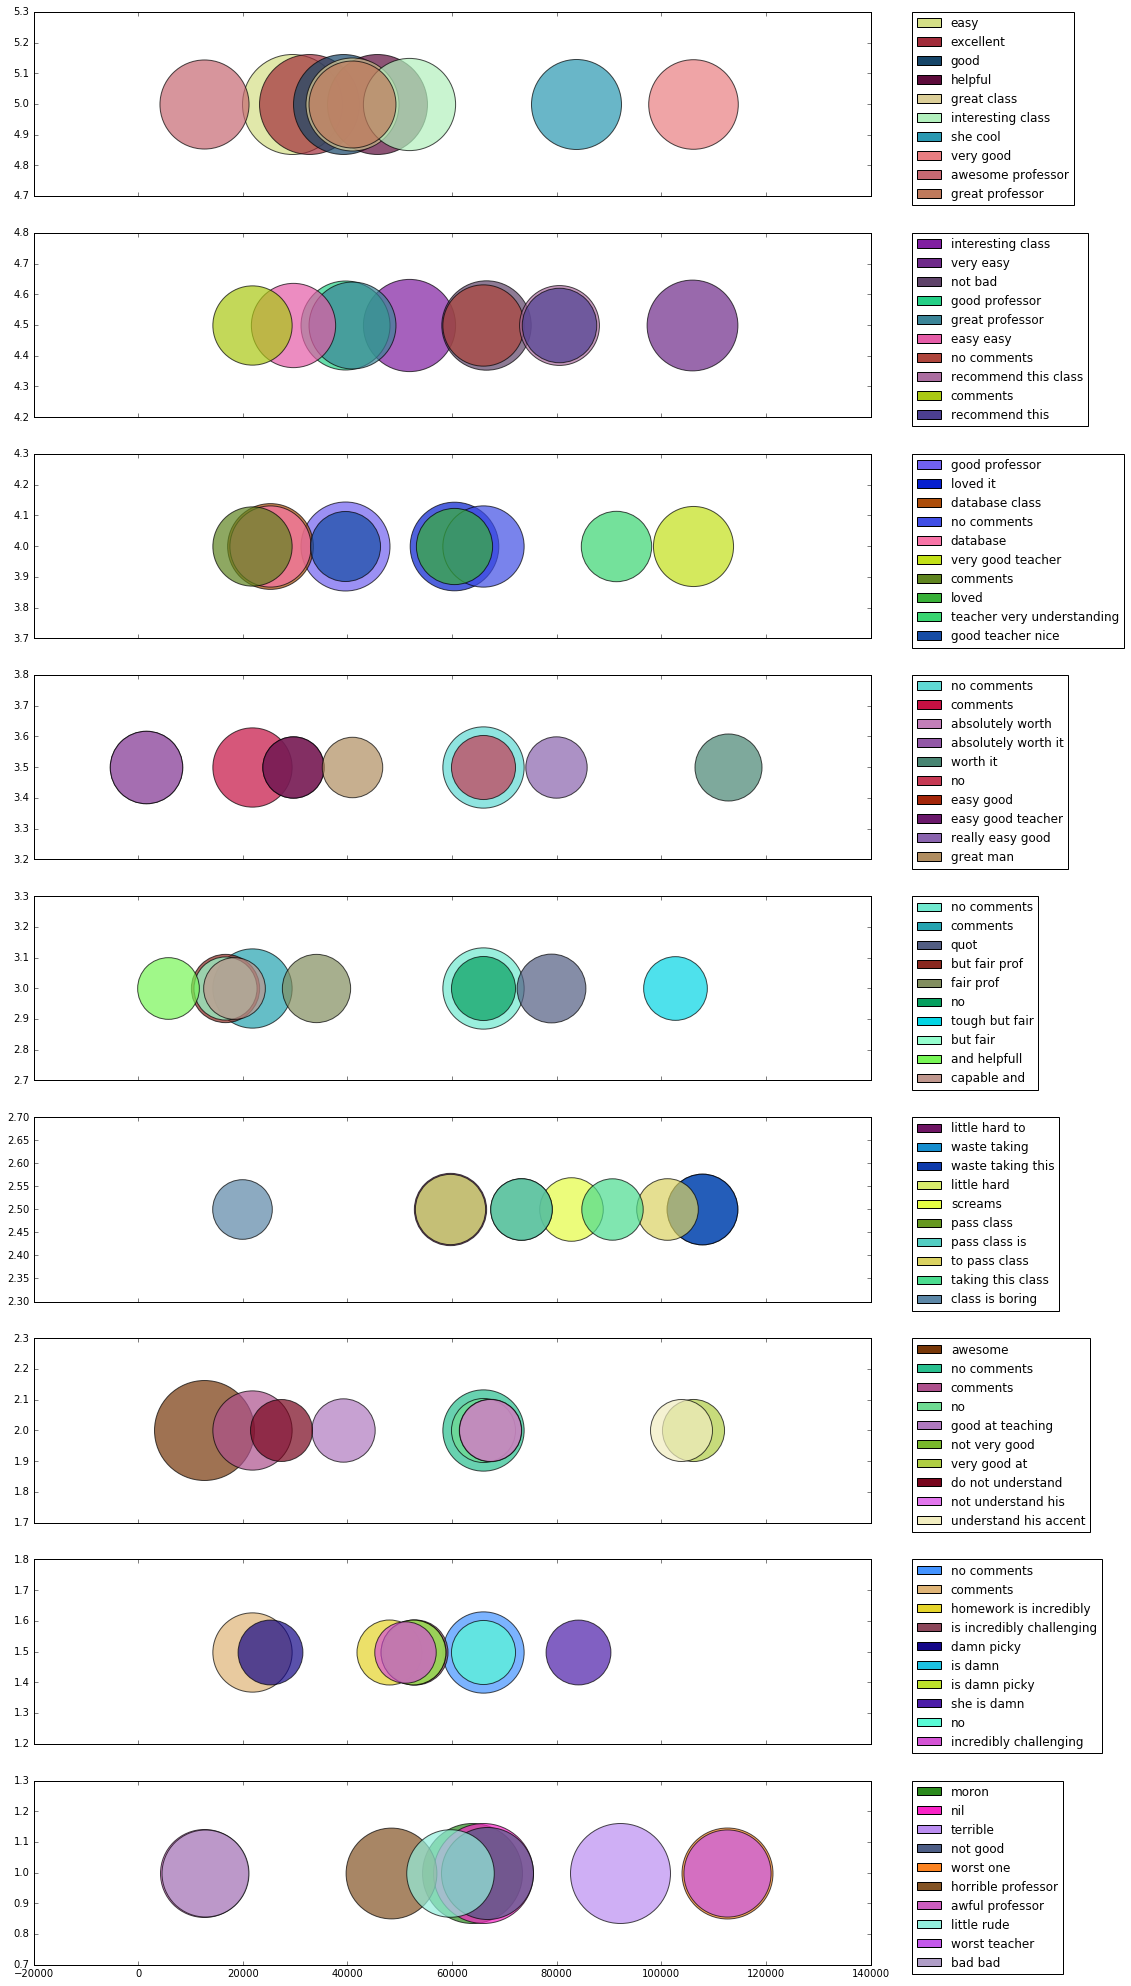

In [65]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 35
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots(len(tempDf['rOverall'].unique()), sharex = True )
OverallSorted = sorted(tempDf['rOverall'].unique(), key=lambda t: t * -1)
for i in OverallSorted:
    recs = []
    classes = []
    for word in tempDf[tempDf['rOverall'] == i]['WordIndex'].unique():
        color  = np.random.rand(3,1)
        ax[OverallSorted.index(i)].scatter(word, i ,s=tempDf[(tempDf['rOverall'] == i) & (tempDf['WordIndex'] == word)]\
                                               ['TF_IDFScores']*10000, c=color, alpha=0.7)
        recs.append(mpatches.Rectangle((0,0),1,1,fc=color))
        classes.append(tempDf[(tempDf['rOverall'] == i) & (tempDf['WordIndex'] == word)]['Names'].unique()[0])
    ax[OverallSorted.index(i)].legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)